In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline

In [6]:
pd.set_option('display.max_columns',100)

df = pd.read_csv('HDB_Resale_Prices.csv')
print(df.head())
print(df.info())
print(df.isnull().sum())

df['month'] = pd.to_datetime(df['month'])
df['sale_year'] = df['month'].dt.year
df['sale_month'] = df['month'].dt.month

     month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.

In [7]:
def parse_remaining_lease(s):
    if pd.isna(s):
        return np.nan
    s = str(s).lower()
    years = 0
    months = 0
    year_match = re.search(r'(\d+)\s+year',s)
    month_match = re.search(r'(\d+)\s+month',s)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(parse_remaining_lease)
#print(df['remaining_lease_years'].head())

def parse_storey_range(s):
    if pd.isna(s):
        return (np.nan,np.nan,np.nan)
    try:
        parts = str(s).split('TO')
        low = int(parts[0].strip())
        high = int(parts[1].strip())
        mid = (low + high) / 2
        return low,high,mid
    except Exception:
        return (np.nan,np.nan,np.nan)

In [8]:
storey_parsed = df['storey_range'].apply(parse_storey_range)
df['storey_low'] = storey_parsed.apply(lambda x: x[0])
df['storey_high'] = storey_parsed.apply(lambda x: x[1])
df['storey_mid'] = storey_parsed.apply(lambda x: x[2])

df['lease_age_at_sale'] = df['sale_year'] - df['lease_commence_date']
df['lease_age_2025'] = 2025 - df['lease_commence_date']

# print(df.describe())
df['resale_price'] = df['resale_price']
print(df['resale_price'].head())

df = df[(df['floor_area_sqm'] > 20) & (df['floor_area_sqm'] < 300)]

0    232000.0
1    250000.0
2    262000.0
3    265000.0
4    265000.0
Name: resale_price, dtype: float64


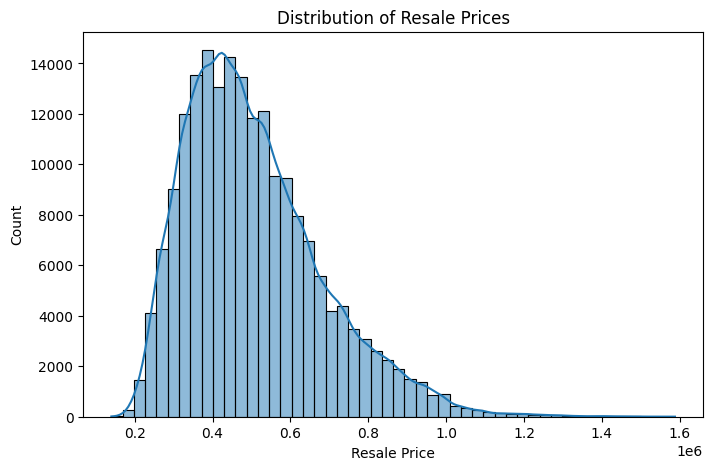

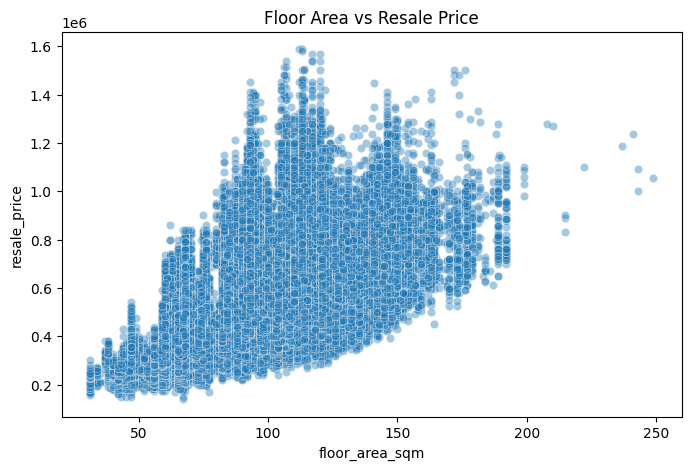

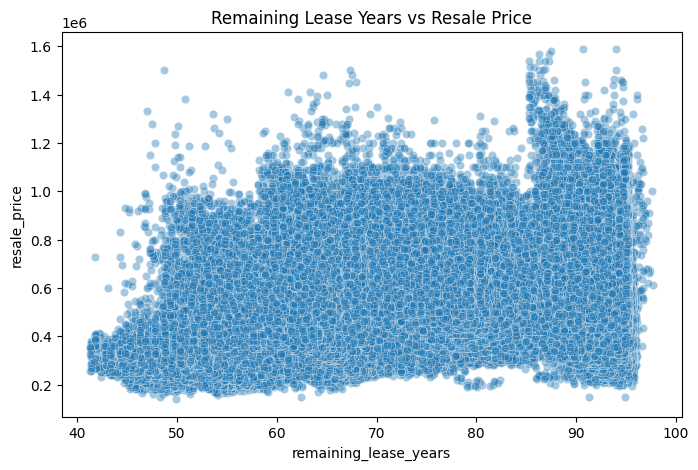

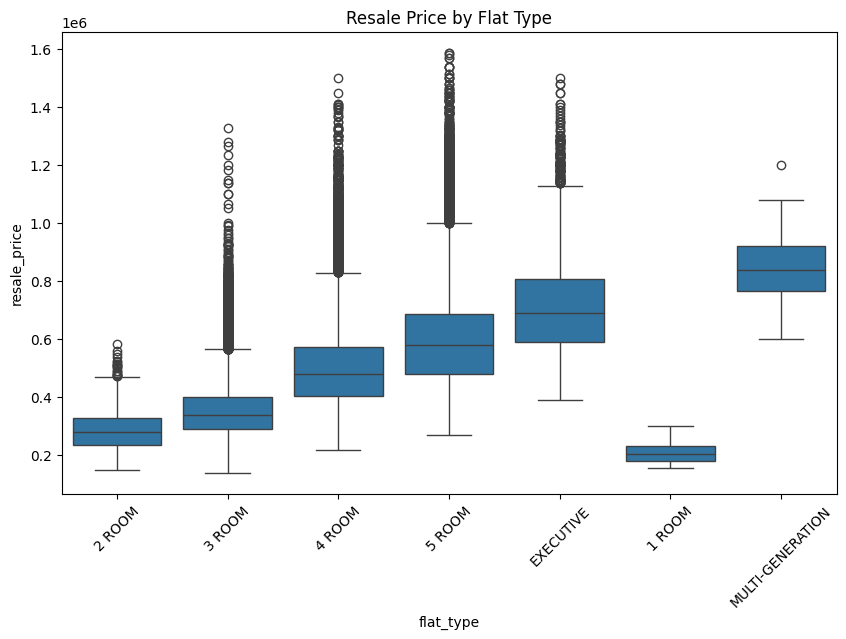

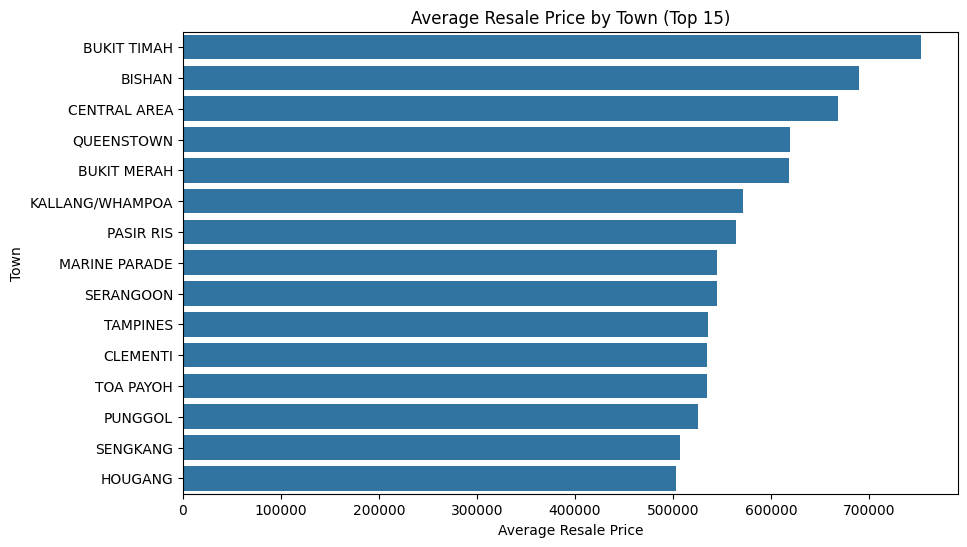

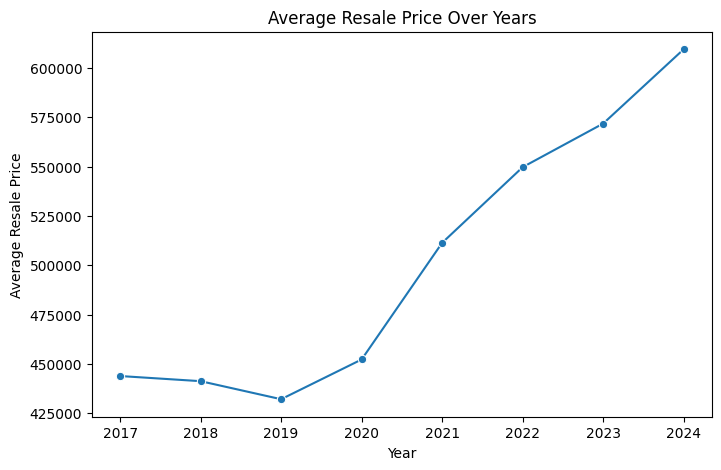

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['resale_price'],bins=50,kde=True)
plt.title('Distribution of Resale Prices')
plt.xlabel('Resale Price')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df,x='floor_area_sqm',y='resale_price',alpha=0.4)
plt.title('Floor Area vs Resale Price')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df,x='remaining_lease_years',y='resale_price',alpha=0.4)
plt.title('Remaining Lease Years vs Resale Price')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='flat_type', y='resale_price')
plt.title('Resale Price by Flat Type')
plt.xticks(rotation=45)
plt.show()

town_mean = df.groupby('town')['resale_price'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=town_mean.values,y=town_mean.index)
plt.title('Average Resale Price by Town (Top 15)')
plt.xlabel('Average Resale Price')
plt.ylabel('Town')
plt.show()

year_mean = df.groupby('sale_year')['resale_price'].mean()
plt.figure(figsize=(8,5))
sns.lineplot(x=year_mean.index,y=year_mean.values,marker='o')
plt.title('Average Resale Price Over Years')
plt.xlabel('Year')
plt.ylabel('Average Resale Price')
plt.show()

In [10]:
mature_towns = {
    'ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'CLEMENTI',
    'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS',
    'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'HOUGANG',
    'JURONG EAST', 'JURONG WEST', 'WOODLANDS', 'YISHUN'
}

df['is_mature_estate'] = df['town'].str.upper().isin(mature_towns).astype(int)
feature_cols = [
    'floor_area_sqm',
    'remaining_lease_years',
    'lease_age_at_sale',
    'storey_mid',
    'sale_year',
    'sale_month',
    'town',
    'flat_type',
    'flat_model',
    'is_mature_estate'
]
target_col = 'resale_price'
df_model = df[feature_cols + [target_col]].copy()
#print(df_model.head())
numeric_features = [
    'floor_area_sqm',
    'remaining_lease_years',
    'lease_age_at_sale',
    'storey_mid',
    'sale_year',
    'sale_month',
    'is_mature_estate'
]

categorical_features = [
    'town',
    'flat_type',
    'flat_model'
]

In [11]:
x = df_model[feature_cols]
y = df_model[target_col]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
#print(len(x_train),len(x_test))

def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

preprocessor = ColumnTransformer([
    ('num',StandardScaler(),numeric_features),
    ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_features)
])

In [12]:
linreg_model = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression())
])

linreg_model.fit(x_train,y_train)
y_pred_linreg = linreg_model.predict(x_test)
r2_linreg = r2_score(y_test,y_pred_linreg)
rmse_linreg = rmse(y_test,y_pred_linreg)

print('Average Price: {:,.0f}$'.format(np.average(df['resale_price'])))

print(f"Linear Regression R²:   {r2_linreg:.3f}")
print(f"Linear Regression RMSE: {rmse_linreg:,.0f}")

Average Price: 506,238$
Linear Regression R²:   0.864
Linear Regression RMSE: 65,144


In [13]:
rf_model = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=1
    ))
])

rf_model.fit(x_train,y_train)
y_pred_rf = rf_model.predict(x_test)
r2_rf = r2_score(y_test,y_pred_rf)
rmse_rf = rmse(y_test,y_pred_rf)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.3s finished


In [14]:
print(f"Random Forest R²:   {r2_rf:.3f}")
print(f"Random Forest RMSE: {rmse_rf:,.0f}")

Random Forest R²:   0.957
Random Forest RMSE: 36,893


In [15]:
results = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest'],
    'R2': [r2_linreg,r2_rf],
    'RMSE': [rmse_linreg,rmse_rf]
})
# print(results)
ohe = rf_model.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features,ohe_feature_names])

rf_reg = rf_model.named_steps['regressor']
importances = rf_reg.feature_importances_

feature_df = pd.DataFrame({
    'feature':all_feature_names,
    'importance':importances
}).sort_values(by='importance',ascending=False)

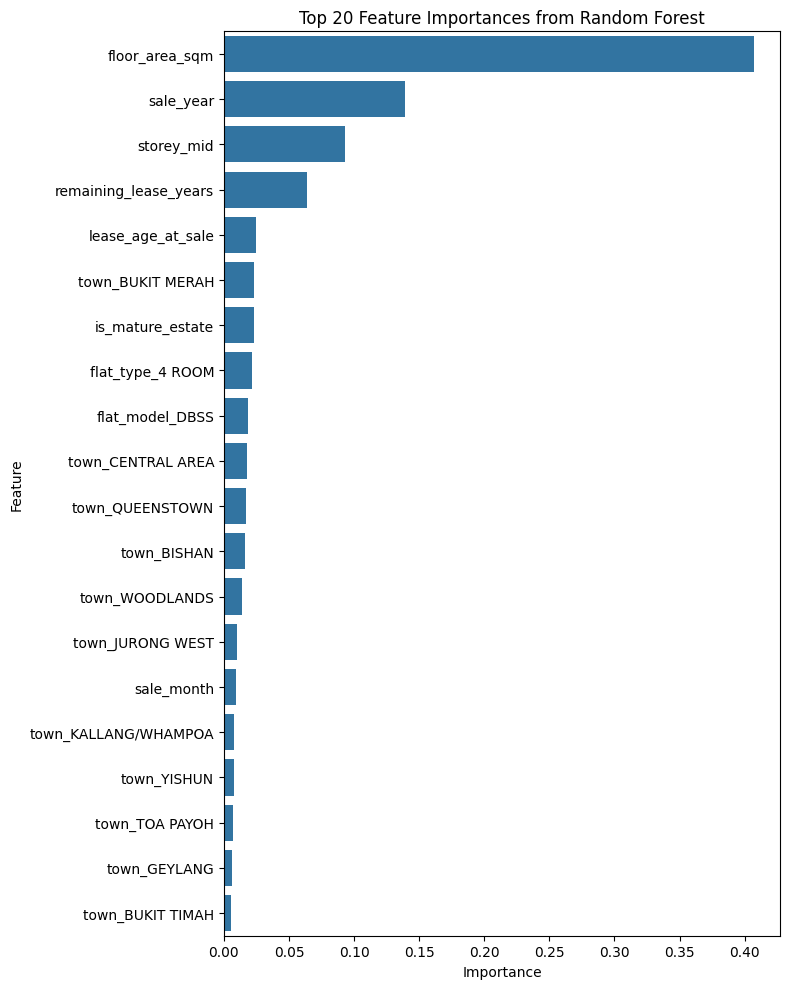

In [16]:
plt.figure(figsize=(8,10))
sns.barplot(data=feature_df.head(20),x='importance',y='feature')
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [17]:
type_price = (df[df['flat_type'].isin(['3 ROOM','5 ROOM'])]
              .groupby('flat_type')['resale_price']
              .agg(['mean','median','count'])
              .sort_index())
print(type_price)

                    mean    median  count
flat_type                                
3 ROOM     357290.294974  340000.0  46070
5 ROOM     602847.920691  580000.0  48091


In [18]:
corr_by_town = (df.groupby('town')[['remaining_lease_years','resale_price']]
                .corr()
                .unstack()
                ['remaining_lease_years']['resale_price']
                .sort_values(ascending=True))
print(corr_by_town)

town
PASIR RIS         -0.082599
SENGKANG          -0.061895
MARINE PARADE     -0.060567
BUKIT PANJANG     -0.039756
PUNGGOL            0.034587
SEMBAWANG          0.040245
CHOA CHU KANG      0.075285
WOODLANDS          0.141822
SERANGOON          0.185953
HOUGANG            0.197051
JURONG EAST        0.200871
YISHUN             0.230353
TAMPINES           0.262281
JURONG WEST        0.362620
BISHAN             0.400774
BUKIT BATOK        0.505632
BUKIT TIMAH        0.523995
BEDOK              0.542420
CLEMENTI           0.644659
GEYLANG            0.673244
ANG MO KIO         0.677316
KALLANG/WHAMPOA    0.701758
BUKIT MERAH        0.702218
QUEENSTOWN         0.755483
TOA PAYOH          0.817087
CENTRAL AREA       0.820347
Name: resale_price, dtype: float64


In [19]:
print('hello world')

hello world
